### See effect of AGNs on Gxs-Flux correlation

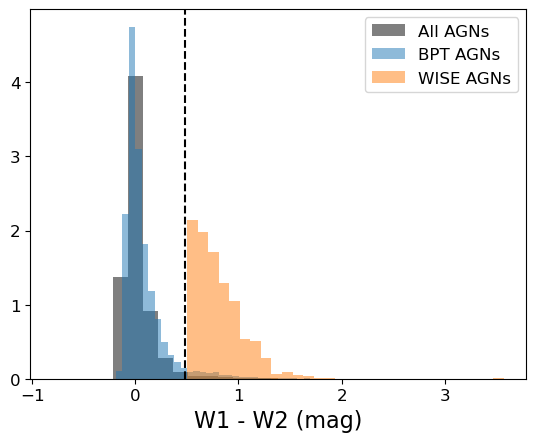

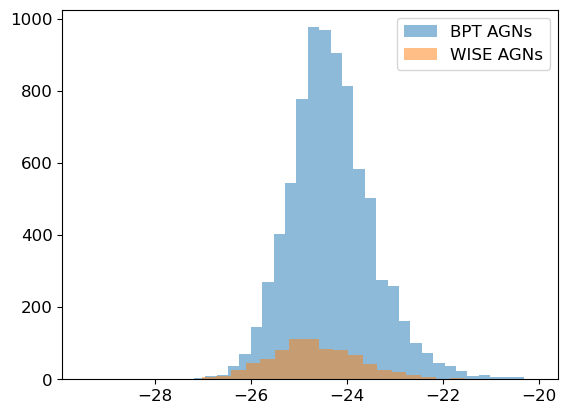

In [8]:
def read_agns(filename='../data/2MRSxWISExZAW2019opticalAGNs.txt', mincz=1200):

    data = ascii.read(filename)

    data = data[data['cz']>mincz]

    #data = data[data['BPTAGN'] == 1]

    #data = data[data['class'] == 1]

    return data

from astropy.io import ascii
import matplotlib.pyplot as plt

data = read_agns()

agns_bpt = data[data['BPTAGN'] == 1]
agns_wise = data[data['class'] == 1]

plt.hist(data['W1mag']-data['W2mag'], bins=30, alpha=0.5, label='All AGNs', color='k', density=True)
plt.hist(agns_bpt['W1mag']-agns_bpt['W2mag'], bins=30, alpha=0.5, label='BPT AGNs', color='C0', density=True)
plt.hist(agns_wise['W1mag']-agns_wise['W2mag'], bins=30, alpha=0.5, label='WISE AGNs', color='C1', density=True)
plt.xlabel('W1 - W2 (mag)')
plt.axvline(0.486, color='k', linestyle='--')
plt.legend()
plt.show()

plt.hist(agns_bpt['K_abs'], bins=30, alpha=0.5, label='BPT AGNs', color='C0')
plt.hist(agns_wise['K_abs'], bins=30, alpha=0.5, label='WISE AGNs', color='C1')
plt.legend()
plt.show()

In [9]:
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import treecorr
import matplotlib.pyplot as plt

def read_catalog(path='../data/', 
                 name='2mrs_1175_done.dat', ncols=29):
  
  with open(path+name, 'r') as file:
    archivo = file.readlines()
    header  = [a.replace('#','').split() for a in archivo[:10]]
    lines   = archivo[10:]
  
  columns = header[-1]
  assert(len(columns) == ncols)
  print("Read %s\nColumns:" % name)
  print(columns)
  
  g = [[] for _ in range(ncols)]     
  for line in lines:
    values = line.split()
    g[0].append(            values[0]);   g[1].append(np.float32(values[1]));   g[2].append(np.float32(values[2]));
    g[3].append(np.float32( values[3]));  g[4].append(np.float32(values[4]));   g[5].append(np.float32(values[5]));
    g[6].append(np.float32( values[6]));  g[7].append(np.float32(values[7]));   g[8].append(np.float32(values[8]));
    g[9].append(np.float32( values[9]));  g[10].append(np.float32(values[10])); g[11].append(np.float32(values[11]));
    g[12].append(np.float32(values[12])); g[13].append(np.float32(values[13])); g[14].append(np.float32(values[14]));
    g[15].append(np.float32(values[15])); g[16].append(np.float32(values[16])); g[17].append(np.float32(values[17]));
    g[18].append(np.float32(values[18])); g[19].append(np.float32(values[19])); g[20].append(np.float32(values[20]));
    g[21].append(           values[21]) ; g[22].append(           values[22]);  g[23].append(values[23]); g[24].append(np.int32(values[24]));
    g[25].append(np.int32(  values[25])); g[26].append(           values[26]);  g[27].append(values[27]); g[28].append(         values[28])
  
  data = Table()
  for idx, col in enumerate(columns):
    data[col] = np.array(g[idx])

  data = data[data['v'] > 1200]  
  
  # Create ks column for K-band absolute magnitude
  from astropy.constants import c
  cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
  comoving_dist = cosmo.comoving_distance((data['v']*u.km/u.s)/c) 
  data['z'] = (data['v']*u.km/u.s / c).to_value(u.one)
  mu = cosmo.distmod(data['z']).value                   # distance modulus in mag (uses D_L correctly)

  data['M_Ks'] = data['k_tc'] - mu  # - Kcorr - Aext

  data['_RAJ2000'] = data['RAdeg']  
  data['_DEJ2000'] = data['DECdeg']  
  data['cz'] = data['v']

  return data

def read_agns(filename='../data/2MRSxWISExZAW2019opticalAGNs.txt', mincz=1200):

    data = ascii.read(filename)

    data = data[data['cz']>mincz]

    data = data[(data['BPTAGN'] == 1)|(data['class'] == 1)]  # Filter for BPT AGNs and WISE AGNs

    return data

def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    rand_ra = np.random.uniform(0, 360, N_total)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))
    return rand_ra, rand_dec

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "num_bootstrap": 50,
    "cross_patch_weight": 'geom'
}

"""
READ DATA
"""
# === Load galaxy catalogue ===
gxs = read_catalog()

# Validate gxs catalog
required_columns = ['_RAJ2000', '_DEJ2000', 'cz']
for col in required_columns:
    if col not in gxs.colnames:
        raise ValueError(f"Missing required column '{col}' in galaxy catalog.")
    
# === Load AGN catalogue ===
agns = read_agns()
agns_bpt = data[data['BPTAGN'] == 1]
agns_wise = data[data['class'] == 1]

# === Load flux catalog ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg', npatch=10)
 

Read 2mrs_1175_done.dat
Columns:
['ID', 'RAdeg', 'DECdeg', 'l', 'b', 'k_c', 'h_c', 'j_c', 'k_tc', 'h_tc', 'j_tc', 'e_k', 'e_h', 'e_j', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'b/a', 'flgs', 'type', 'ts', 'v', 'e_v', 'c', 'vsrc', 'CAT_ID']


Text(0.5, 0, 'K_abs')

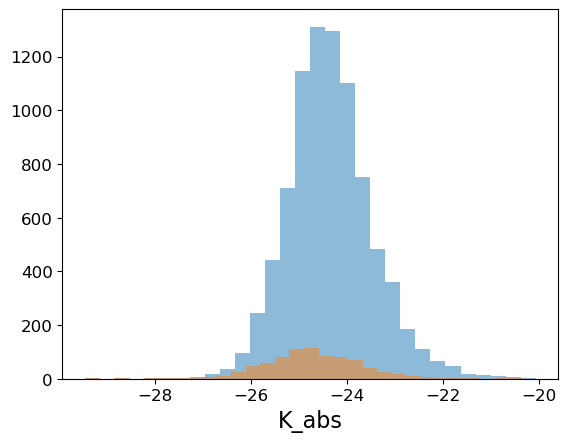

In [10]:
plt.hist(agns['K_abs'], bins=30, alpha=0.5)
plt.hist(agns[agns['class']==1]['K_abs'], bins=30, alpha=0.5)
plt.xlabel('K_abs')

In [4]:
print('N. of BPT:', len(agns_bpt))
print('N. of WISE:', len(agns_wise))

N. of BPT: 8024
N. of WISE: 801


In [5]:
print('N. of BPT w/ -22<K<20:', len(agns_bpt[(agns_bpt['K_abs'] <= -20.0) & (agns_bpt['K_abs'] >= -22.0)]))
print('N. of WISE w/ -22<K<20:', len(agns_wise[(agns_wise['K_abs'] <= -20.0) & (agns_wise['K_abs'] >= -22.0)]))

N. of BPT w/ -22<K<20: 101
N. of WISE w/ -22<K<20: 8


### Checking cz distribution

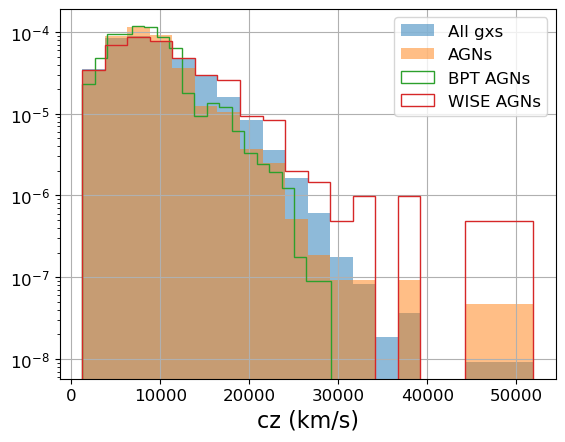

In [17]:
plt.hist(gxs['cz'], bins=20, alpha=0.5, label='All gxs', density=True)
plt.hist(agns['cz'], bins=20, alpha=0.5, label='AGNs', density=True)
plt.hist(agns_bpt['cz'], bins=20, alpha=1, label='BPT AGNs', density=True, histtype='step')
plt.hist(agns_wise['cz'], bins=20, alpha=1, label='WISE AGNs', density=True, histtype='step')
plt.yscale('log')
plt.xlabel('cz (km/s)')
plt.grid()
plt.legend()
plt.show()

Processing: All
N. of galaxies: 42910
Processing: WISE AGNs
N. of galaxies: 801


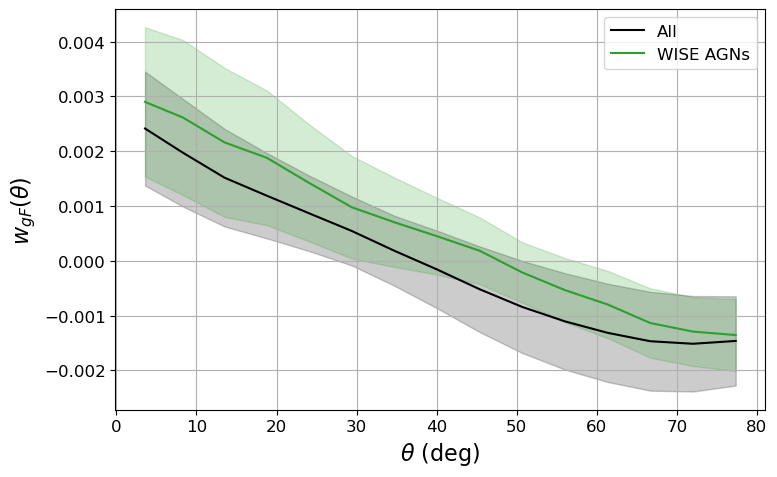

In [19]:

"""
CALCULATE CORRELATIONS FOR samples
"""

fig, ax = plt.subplots(figsize=(8, 5))

samples = ['All', 'WISE AGNs']
colors = ['k', 'C2']  # Colors for each sample

for color, sample in zip(colors, samples):

    print('Processing:', sample)

    if sample == 'All':
        gxs_slice = gxs
    elif sample == 'BPT AGNs':
        gxs_slice = agns_bpt
    elif sample == 'WISE AGNs':
        gxs_slice = agns_wise

    print('N. of galaxies:', len(gxs_slice))

    # Generate random catalog for the current slice
    rand_ra, rand_dec = generate_RanCat(len(gxs_slice)*10, dec_min=-90, dec_max=45)

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['_RAJ2000'], dec=gxs_slice['_DEJ2000'],
                                  ra_units='deg', dec_units='deg', npatch=10)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, 
                                ra_units='deg', dec_units='deg', patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    xi, varxi = nk.calculateXi(rk=rk)

    xi = xi / flux_val.mean()  # Normalize by mean flux value

    plt.fill_between(nk.meanr, xi - varxi**0.5, xi + varxi**0.5, 
                     color=color, alpha=0.2)  # Add error band
    plt.plot(nk.meanr, xi, color=color, label=f'{sample}')

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 18,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
plt.show()

Processing: All
N. of galaxies: 879


Processing: AGNs
N. of galaxies: 104


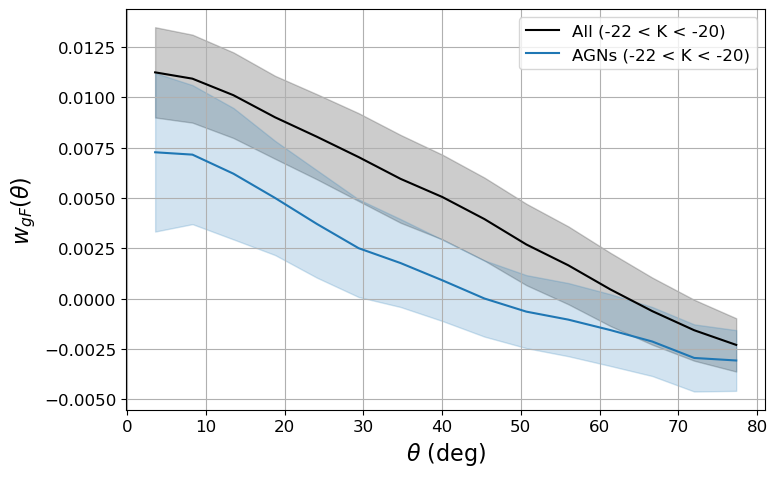

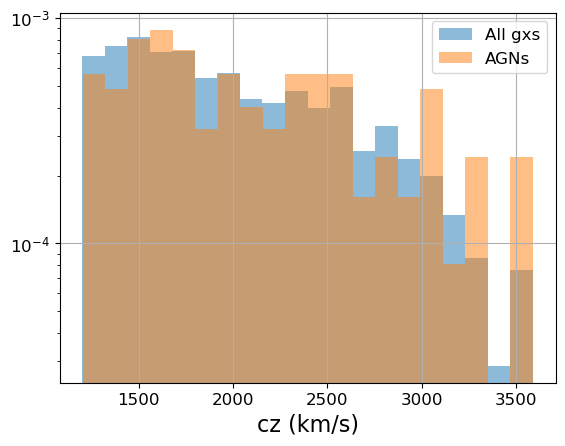

In [ ]:

"""
CALCULATE CORRELATIONS FOR samples
"""
fig, ax = plt.subplots(figsize=(8, 5))

samples = ['All', 'AGNs']
colors = ['k', 'C0']  # Colors for each sample

# === CUT IN K ===
agns_K = agns[(agns['K_abs'] <= -20.0)&(agns['K_abs'] >= -22.0)]  # Apply magnitude cut for AGNs
gxs_K = gxs[(gxs['M_Ks'] <= -20.0)&(gxs['M_Ks']>=-22.)]  # Apply magnitude cut

for color, sample in zip(colors, samples):

    print('Processing:', sample)

    if sample == 'All':
        gxs_slice = gxs_K
    elif sample == 'AGNs':
        gxs_slice = agns_K

    print('N. of galaxies:', len(gxs_slice))

    # Generate random catalog for the current slice
    rand_ra, rand_dec = generate_RanCat(len(gxs_slice)*10, dec_min=-90, dec_max=45)

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['_RAJ2000'], dec=gxs_slice['_DEJ2000'],
                                  ra_units='deg', dec_units='deg', npatch=10)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, 
                                ra_units='deg', dec_units='deg', patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    xi, varxi = nk.calculateXi(rk=rk)

    xi = xi / flux_val.mean()  # Normalize by mean flux value

    plt.fill_between(nk.meanr, xi - varxi**0.5, xi + varxi**0.5, 
                     color=color, alpha=0.2)  # Add error band
    plt.plot(nk.meanr, xi, color=color, label=f'{sample} (-22 < K < -20)')

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 18,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
plt.show()



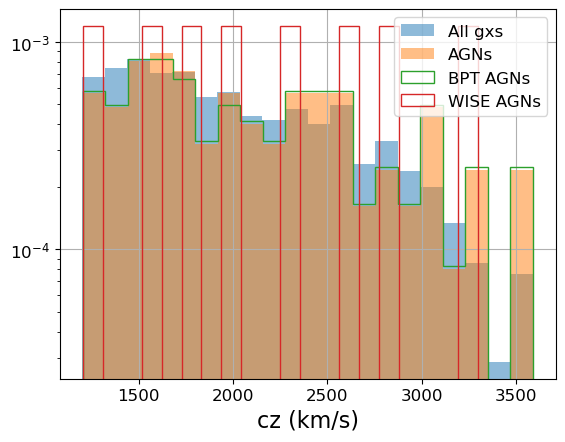

In [23]:
agns_bpt_K = agns_bpt[(agns_bpt['K_abs'] <= -20.0)&(agns_bpt['K_abs'] >= -22.0)]  # Apply magnitude cut for BPT AGNs
agns_wise_K = agns_wise[(agns_wise['K_abs'] <= -20.0)&(agns_wise['K_abs'] >= -22.0)]  # Apply magnitude cut for WISE AGNs

plt.hist(gxs_K['cz'], bins=20, alpha=0.5, label='All gxs', density=True)
plt.hist(agns_K['cz'], bins=20, alpha=0.5, label='AGNs', density=True)
plt.hist(agns_bpt_K['cz'], bins=20, alpha=1, label='BPT AGNs', density=True, histtype='step')
plt.hist(agns_wise_K['cz'], bins=20, alpha=1, label='WISE AGNs', density=True, histtype='step')
plt.yscale('log')
plt.xlabel('cz (km/s)')
plt.grid()
plt.legend()
plt.show()